In [84]:
# Data
import numpy as np
import pandas as pd
import glob
import os

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Combine datasets

In [51]:
# combine all datsets into one big dataset and save to parquet

path = r'' 

all_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

#--- data cleaning ---

# drop row number column
df = df.drop("No", axis=1)

# replace column names
def change_column_name(name):
    name = name.lower()
    
    if name == 'pm2.5':
        name = "pm25"
    if name == "temp":
        name = "temperatur"
    if name == "pres":
        name = "pressure"
    if name == "dewp":
        name = "dew_point"
    if name == "wd":
        name = "wind_direction"
    if name == "wspm":
        name = "wind_speed"
        
    return name

column_names = list(df.columns)
column_names = [change_column_name(x) for x in column_names]
df.columns = column_names

df.to_parquet("prsa_data.parquet")

In [52]:
df.columns

Index(['year', 'month', 'day', 'hour', 'pm25', 'pm10', 'so2', 'no2', 'co',
       'o3', 'temperatur', 'pressure', 'dew_point', 'rain', 'wind_direction',
       'wind_speed', 'station'],
      dtype='object')

# EDA - air quality dataset

In [69]:
aq = pd.read_parquet("prsa_data.parquet")

In [70]:
aq.head()

,year,month,day,hour,pm25,pm10,so2,no2,co,o3,temperatur,pressure,dew_point,rain,wind_direction,wind_speed,station
0,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng


In [73]:
# Description of the columns
print('Data: '+'\x1b[1;31m'+'prsa'+'\x1b[0m'+ ", nrows: {}, ncols: {}".format(aq.shape[0],aq.shape[1]))
print("\033[1m\033[4m\033[95m{:<27} :  {:<7}  {:<50} |  {:>9} {:>9} {:>9} {:>10} {:>10} ({:>4}%)\033[0m".format("column", "type", "samples", "Mean", "Median", "Min", "Max", "Nans", "Nans"))
for column in aq.columns:
    
    column_type = str(aq.dtypes[column])
    
    samples = aq[column].dropna().sample(10).tolist()
    if column_type == "object":
        samples = ["'"+value+"'" for value in samples]
        samples = "  ".join([str(value) for value in samples])[:50]
    else:
        samples = "  ".join([str(round(value,2)) for value in samples])[:50]
    
    mean = "-"
    median = "-"
    mini = "-"
    maxi = "-"
    if column_type != "object":
        mean = round(aq[column].mean(),2)
        median = round(aq[column].median(),2)
        mini = round(aq[column].min(),2)
        maxi = round(aq[column].max(),2)
    
    nans_perc = round(aq[column].isnull().sum() * 100 / len(aq[column]),1)
    nans = aq[column].isnull().sum()
    
    out = "{:<27} :  {:<7}  {:<50} |  {:>9} {:>9} {:>9} {:>10} {:>10} ({}%)".format(column, column_type, samples, str(mean), str(median), str(mini), str(maxi), nans, nans_perc)
    print(out)

Data: prsa, nrows: 420768, ncols: 17
column                      :  type     samples                                            |       Mean    Median       Min        Max       Nans (Nans%)
year                        :  int64    2015  2015  2014  2013  2015  2014  2015  2014  20 |    2014.66    2015.0      2013       2017          0 (0.0%)
month                       :  int64    3  7  6  1  6  7  12  11  5  12                    |       6.52       7.0         1         12          0 (0.0%)
day                         :  int64    6  21  26  5  18  30  30  1  20  25                |      15.73      16.0         1         31          0 (0.0%)
hour                        :  int64    0  19  4  12  15  16  18  13  19  1                |       11.5      11.5         0         23          0 (0.0%)
pm25                        :  float64  85.0  263.0  104.1  19.0  16.0  76.0  122.0  71.0  |      79.79      55.0       2.0      999.0       8739 (2.1%)
pm10                        :  float64  199.

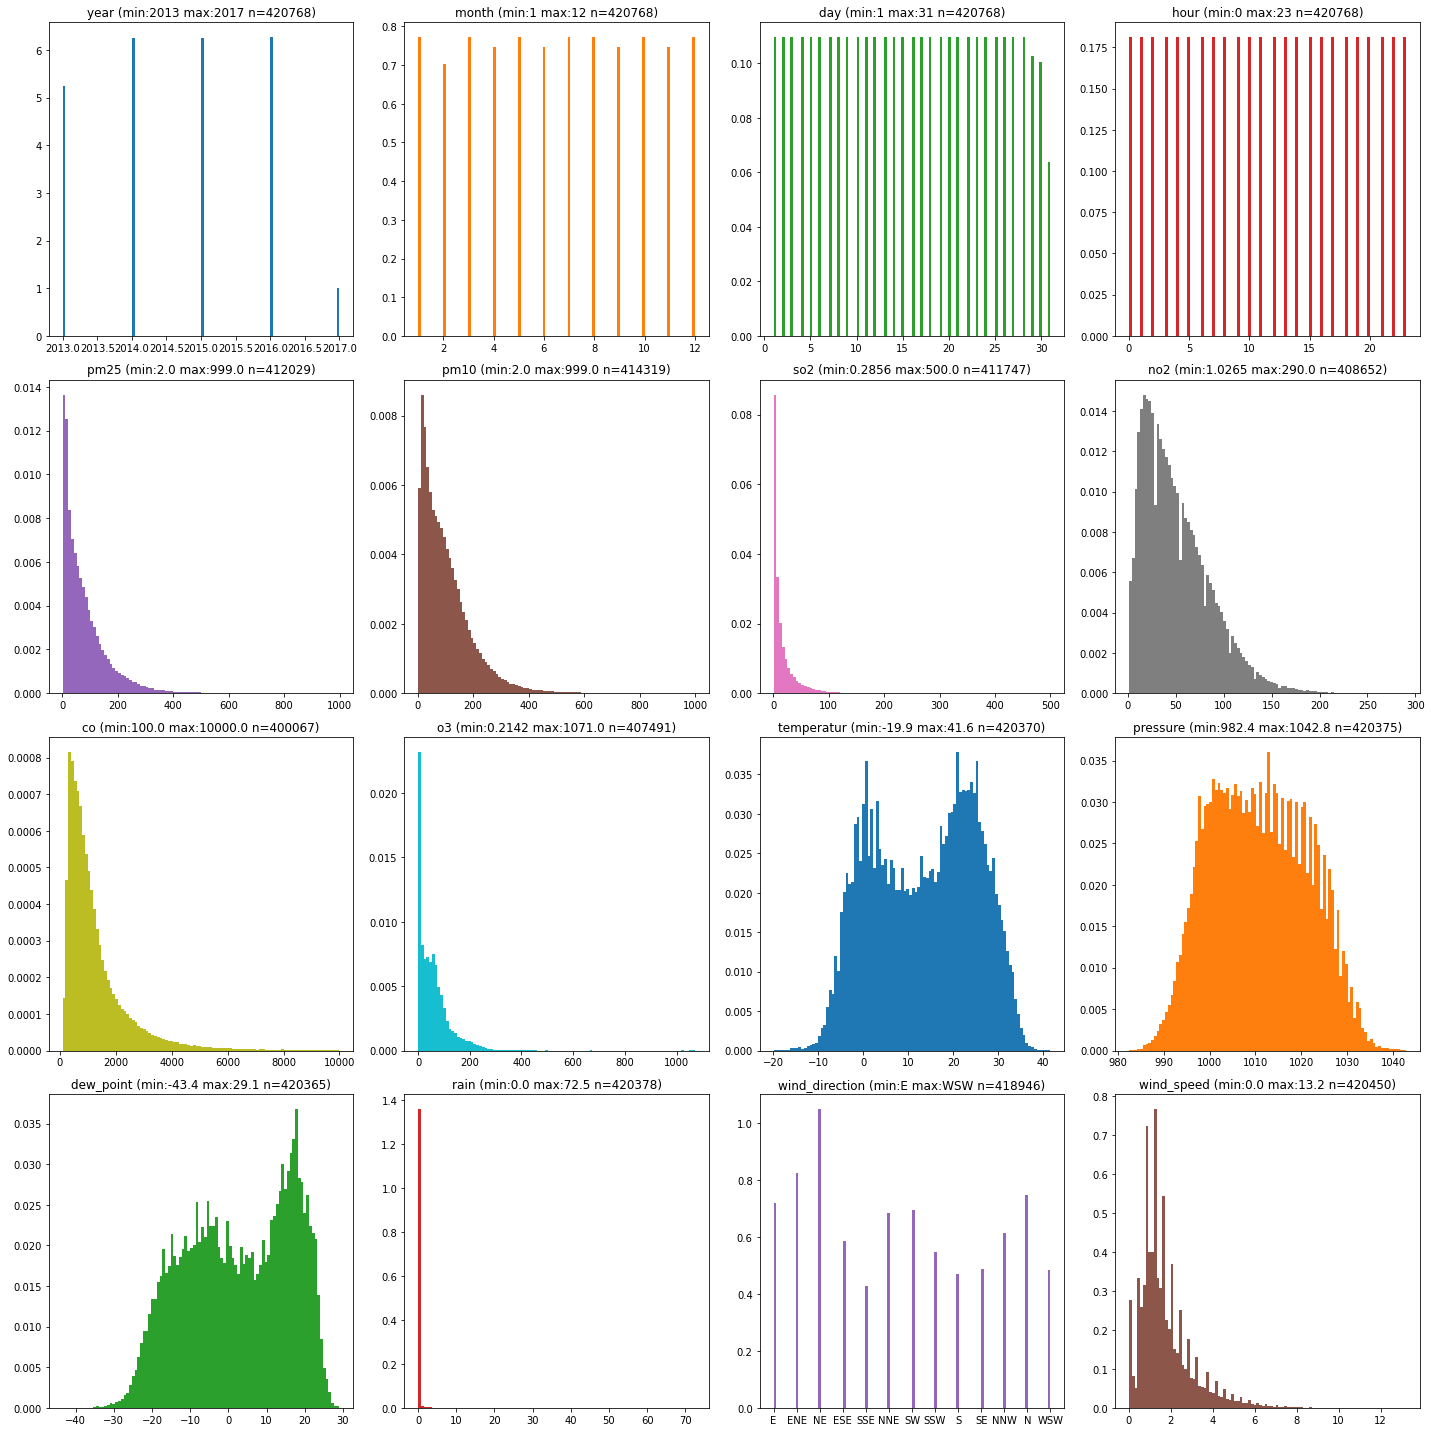

In [81]:
fig, axs = plt.subplots(4, 4)
fig.set_figheight(20)
fig.set_figwidth(20)

colors = plt.rcParams["axes.prop_cycle"]()

for i, ax in enumerate(fig.axes):
        
        if i < len(aq.columns):
            
            # get column name
            column_name = aq.columns[i]
            print("Creating column {}/{} - {}".format(i, len(aq.columns), column_name), end="\r")
            
            # Extract data
            series = aq[column_name].dropna()
            
            # Create subplot
            color = next(colors)["color"]
            
            ax.hist(series, density=True, bins=100, color= color, range=(series.min(), series.max()))
            ax.set_title(column_name+" (min:{} max:{} n={})".format(series.min(),series.max(), series.count()))

            
fig.tight_layout()        
#fig.savefig("../master-thesis/figures/column_distribution.png")

In [82]:
# Columns with highest missing values
nans_in_column = {}
for column in aq.columns:
    
    nans_perc = round(aq[column].isnull().sum() * 100 / len(aq[column]),1)
    nans = aq[column].isnull().sum()
    
    nans_in_column[column] = nans_perc

nans_in_column = {k: v for k, v in sorted(nans_in_column.items(), key=lambda item: item[1])}

for key, value in nans_in_column.items():
    print("{:>26} - {}%".format(key,value))

                      year - 0.0%
                     month - 0.0%
                       day - 0.0%
                      hour - 0.0%
                   station - 0.0%
                temperatur - 0.1%
                  pressure - 0.1%
                 dew_point - 0.1%
                      rain - 0.1%
                wind_speed - 0.1%
            wind_direction - 0.4%
                      pm10 - 1.5%
                      pm25 - 2.1%
                       so2 - 2.1%
                       no2 - 2.9%
                        o3 - 3.2%
                        co - 4.9%


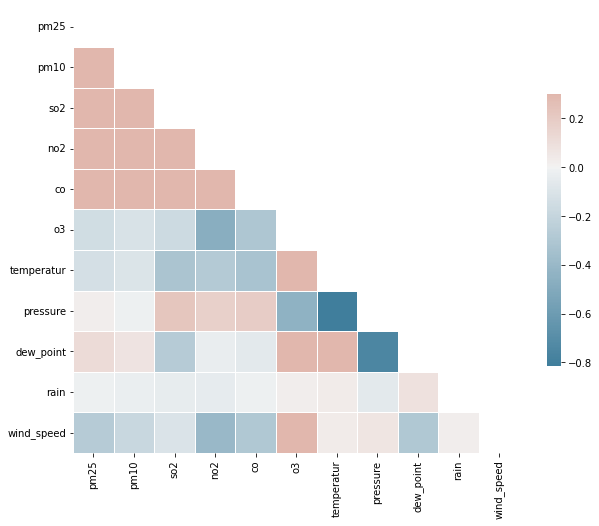

In [93]:
# correlation between variables
corr = aq.iloc[:,4:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

- **temperature** and **pressure** have a high negative correlation
- **dewpoint** and **pressure** have a high negative correlation
- **chemical measurements** have a slight positive correlation with each other 

In [5]:
from pathlib import Path
relative = Path("prsa_data.parquet")
absolute = relative.absolute()  # absolute is a Path object
absolute

PosixPath('/home/yannic/master-thesis/data_air/prsa_data.parquet')